
**GCC-PHAT (generalized cross correlation Phase Transform) baisc principle**

1. Conduct fourier transfrom on the signals respectively received by two microphones.

2. Calculate the cross spectral density of two signals in the frequency domain.

3. Apply phase transform to normalize and retain only the phase information.

4. Obtain cross-correlation by performing inverse fourier transform.

5. Find the sample delay where cross correlation is maximized.

6. Calculate the DoA using the TDoA, microphone distance, sound speed, and other microphone array information.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import find_peaks


folder = "data/240604/103.5"
sr = 48000

# bottom, top
sig1, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_1.wav", sr=None)
sig2, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_2.wav", sr=None)

## GCC-PHAT ##
def gcc_phat(sig1, sig2, sr):
    n = sig1.size + sig2.size
    
    SIG1 = np.fft.rfft(sig1, n=n)
    SIG2 = np.fft.rfft(sig2, n=n)
    
    R = SIG1 * np.conj(SIG2)
    cc = np.fft.irfft(R / np.abs(R))
    
    # cross-correlation = sample delay
    # TDoA = sample delay / sampling rate

    # max_shift -> How the signal is delayed relative to another
    # cc -> consider all possible delays in the range -max shift ~ +max_shift
    
    # Due to FFT, the cross-correlation function has circular properties.
    # The process of converting linear convolution result is necessary.
    # So, the result of the cross-correlation function is shifted and converted to center-based form.
    
    sample_delay = 0
    max_shift = n // 2
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift]))
    sample_delay = np.argmax(cc) - max_shift
    tdoa = sample_delay / float(sr)

    return cc, tdoa

# tdoa = cos(doa) * distance / sound_speed
cc, tdoa = gcc_phat(sig1, sig2, sr)
distance = 0.161
sound_speed = 343.2
doa = np.arccos(tdoa * sound_speed / distance)
print(f"Azimuth: {np.degrees(doa)-90:.4f}")

Azimuth: 20.8106


/tmp/ipykernel_432965/2420383527.py:3: RuntimeWarning: invalid value encountered in arccos
  angles = np.degrees(np.arccos(lags * sound_speed / distance)) - 90


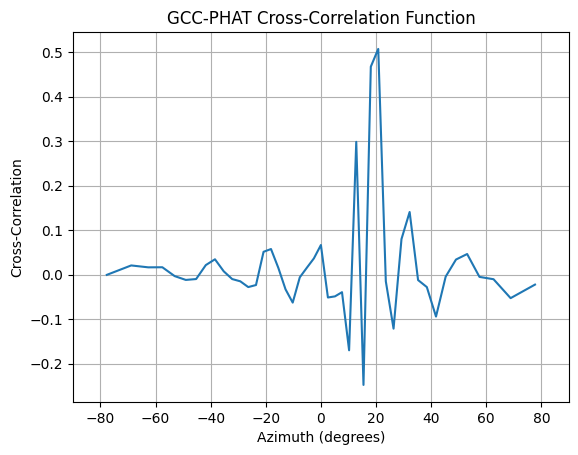

In [2]:
max_lag = cc.size // 2
lags = np.arange(-max_lag, max_lag) / float(sr)
angles = np.degrees(np.arccos(lags * sound_speed / distance)) - 90

plt.plot(angles, cc)
plt.title('GCC-PHAT Cross-Correlation Function')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Cross-Correlation')
plt.xlim(-90, 90)
plt.grid(True)
plt.show()